In [1]:
import os
from glob import glob
import gzip
import json
from pathlib import Path

import h5py
from tokenizers import ByteLevelBPETokenizer
import pandas as pd
import matplotlib.pyplot as plt

from deepcode.config import parse_config
from deepcode.train.data import CodeDataset

In [2]:
languages = ["java", "javascript", "python", "php", "ruby", "go"]
device = "cpu"
with open("config.toml", "r") as f:
    config = parse_config(f.read())
file = h5py.File(config.training.data_train, "r")
data = {
    lang: CodeDataset(file[lang], lang, device)
    for lang in languages
}

In [3]:
for lang, dataset in data.items():
    print(f"Language: {lang}, # of items: {len(dataset)}")


Language: java, # of items: 454451
Language: javascript, # of items: 81463
Language: python, # of items: 412168
Language: php, # of items: 523712
Language: ruby, # of items: 48791
Language: go, # of items: 317831


In [4]:
tokenizer_doc = ByteLevelBPETokenizer("../cache/vocabs/doc-vocab.json", "../cache/vocabs/doc-merges.txt")
tokenizer_java = ByteLevelBPETokenizer("../cache/vocabs/code-java-vocab.json", "../cache/vocabs/code-java-merges.txt")


In [5]:
def print_sample(idx: int):
    language, (code_tokens, code_mask, doc_tokens, doc_mask, name_tokens, name_mask) = data["java"][idx]
    code_tokens = code_tokens[code_mask]
    print(tokenizer_java.decode_batch(list([i] for i in code_tokens)))

print_sample(0)

['protected', 'final', 'void', 'bind', 'Indexed', '(', 'Configuration', 'PropertyName', 'name', ',', 'Bind', 'able', '<', '?', '>', 'target', ',', 'Aggregate', 'Element', 'Binder', 'element', 'Binder', ',', 'Resol', 'v', 'ableType', 'aggregate', 'Type', ',', 'Resol', 'v', 'ableType', 'elementType', ',', 'Indexed', 'Collection', 'Supplier', 'result', ')', '{', 'for', '(', 'Configuration', 'Property', 'Source', 'source', ':', 'getContext', '(', ')', '.', 'getS', 'ources', '(', ')', ')', '{', 'bind', 'Indexed', '(', 'source', ',', 'name', ',', 'target', ',', 'element', 'Binder', ',', 'result', ',', 'aggregate', 'Type', ',', 'elementType', ')', ';', 'if', '(', 'result', '.', 'was', 'Sup', 'plied', '(', ')', '&&', 'result', '.', 'get', '(', ')', '!=', 'null', ')', '{', 'return', ';', '}', '}', '}']


In [6]:
with gzip.open("../resources/data/java/final/jsonl/train/java_train_0.jsonl.gz", "r") as f:
    res = [f.readline() for _ in range(5)]
res = [json.loads(s) for s in res]


In [7]:
def print_from_lines(idx: int):
    print(res[idx]["code_tokens"])

print_from_lines(0)

['protected', 'final', 'void', 'bindIndexed', '(', 'ConfigurationPropertyName', 'name', ',', 'Bindable', '<', '?', '>', 'target', ',', 'AggregateElementBinder', 'elementBinder', ',', 'ResolvableType', 'aggregateType', ',', 'ResolvableType', 'elementType', ',', 'IndexedCollectionSupplier', 'result', ')', '{', 'for', '(', 'ConfigurationPropertySource', 'source', ':', 'getContext', '(', ')', '.', 'getSources', '(', ')', ')', '{', 'bindIndexed', '(', 'source', ',', 'name', ',', 'target', ',', 'elementBinder', ',', 'result', ',', 'aggregateType', ',', 'elementType', ')', ';', 'if', '(', 'result', '.', 'wasSupplied', '(', ')', '&&', 'result', '.', 'get', '(', ')', '!=', 'null', ')', '{', 'return', ';', '}', '}', '}']


In [8]:
tokenizer_java.encode("\n").ids

[]

In [9]:
models_dir = "../cache/models"
experiments = glob(f"{models_dir}/*/")
experiments = [{"dir": e} for e in experiments]
for e in experiments:
    print(e["dir"])
    l = {}
    for p in glob(os.path.join(e["dir"], "*.json")):
        key = int(Path(p).name[:-5])
        with open(p, "rt") as f:
            l[key] = json.load(f)
    e["stats"] = [l[k] for k in sorted(l.keys())]
    e["name"] = e["dir"][len(models_dir) + 1 + 20: - 1]

for e in experiments:
    mrrs = [i["mrr"] for i in e["stats"]]
    e["stats"] = pd.DataFrame(mrrs)

../cache/models/2020.04.07_06.43.21-go-javascript-256/
../cache/models/2020.04.05_09.41.54-all-32/
../cache/models/2020.04.06_18.24.03-go-java-256/
../cache/models/2020.04.05_16.58.43-all-256/
../cache/models/2020.04.07_10.28.37-go-php-256/
../cache/models/2020.04.09_19.34.10-go-ruby-256/
../cache/models/2020.04.09_20.51.25-java-javascript-256/
../cache/models/2020.04.07_17.09.37-go-python-256/
../cache/models/2020.04.04_18.29.08-all-128/


In [10]:
max, min = 0, 1
for e in experiments:
    for j in e["stats"]:
        for k in e["stats"][j]:
            if k > max:
                max = k
            if k < min:
                min = k
        

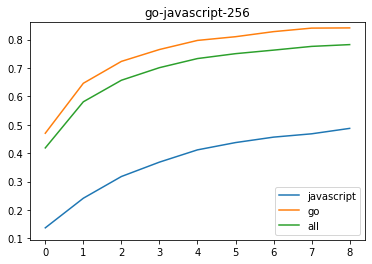

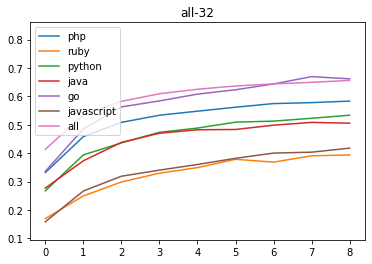

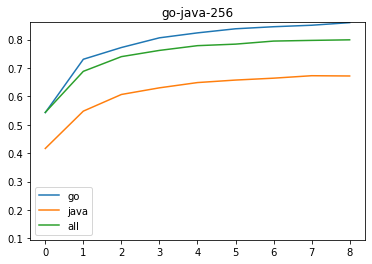

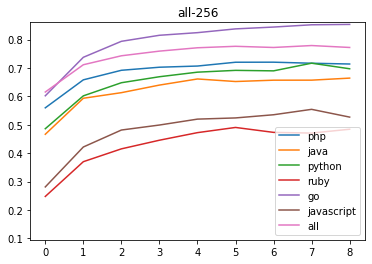

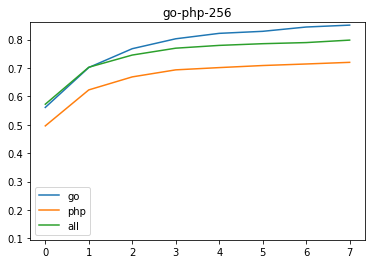

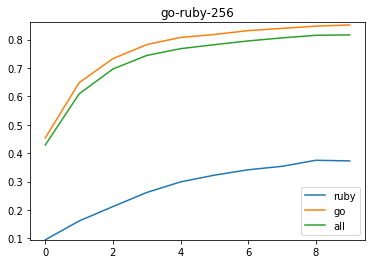

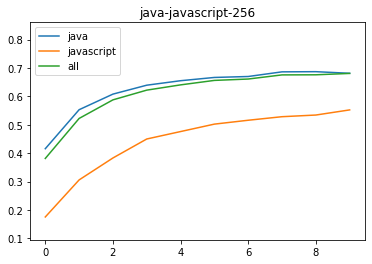

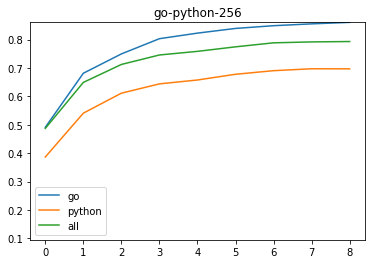

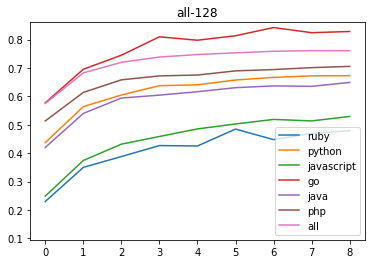

In [11]:
for e in experiments:
    _ = e["stats"].plot()
    plt.title(e["name"])
    plt.ylim(min, max)
    plt.show()
